In [2]:
from datetime import datetime
import warnings
import os

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import RocCurveDisplay, roc_curve
import numpy as np
import holidays
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

set_config(transform_output="pandas")

warnings.filterwarnings("ignore")
os.environ["PYTHONWARNINGS"] = "ignore"

## Load Training and Testing Data

In [3]:
df = pandas.read_csv("troon_instagram_clean_post_data.csv")
df = df.set_index("id")
df = df[["post_month", "post_day", "post_year", "days_since_previous_release", "release_post"]].copy()
df["month"] = df["post_month"].apply(lambda x : datetime.strptime(x, '%B').month)
df = df.rename(columns={"post_year" : "year", "post_day" : "day"})
df["date"] = pandas.to_datetime(df[["year", "month", "day"]])
del df["post_month"]
del df["day"]
del df["month"]
df

,year,days_since_previous_release,release_post,date
id,,,,
50,2016,NaN,False,2016-02-15
123,2016,NaN,False,2016-02-15
173,2016,NaN,False,2016-02-15
156,2016,NaN,False,2016-02-15
133,2016,NaN,False,2016-02-15
...,...,...,...,...
408,2023,7.0,True,2023-06-23
409,2023,10.0,True,2023-07-03
410,2023,3.0,True,2023-07-06


In [4]:
df.query("release_post == True & days_since_previous_release.isnull()")

,year,days_since_previous_release,release_post,date
id,,,,


In [5]:
# df = df[df["days_since_previous_release"].notnull()].copy()

In [6]:
df = df[df["release_post"] == True].copy()

In [7]:
df[df["days_since_previous_release"] == 0]

,year,days_since_previous_release,release_post,date
id,,,,
183,2017,0.0,True,2017-02-17


In [8]:
df = df[df["days_since_previous_release"] != 0].copy()

In [9]:
years = set(df["year"])
nj_holidays = holidays.UnitedStates(state="NJ", years=years)
nj_holidays.append({"{}-03-17".format(y) : "St. Patrick's Day" for y in years})
nj_holidays.append({"{}-02-14".format(y) : "Valentine's Day" for y in years})
del df["year"]

In [10]:
# Super Bowls count as holidays as far as beer is concerned lol
nj_holidays["2016-02-07"] = "Super Bowl 50"
nj_holidays["2017-02-05"] = "Super Bowl LI"
nj_holidays["2018-02-04"] = "Super Bowl LII"
nj_holidays["2019-02-03"] = "Super Bowl LIII"
nj_holidays["2020-02-02"] = "Super Bowl LIV"
nj_holidays["2021-02-07"] = "Super Bowl LV"
nj_holidays["2022-02-13"] = "Super Bowl LVI"
nj_holidays["2023-02-12"] = "Super Bowl LVII"

In [11]:
df = df.sort_values(by=["date"]).set_index("date")
daily = pandas.date_range(df.index.min(), df.index.max(), freq="D")
df = df.reindex(daily, method=None)
df["release_post"] = df["release_post"].fillna(False)

In [12]:
df = df.reset_index()
release_dates = list(df[df["release_post"] == True]["index"])
df["closest_release_date"] = df["index"].apply(lambda x : max([d for d in release_dates if d <= x]))

In [13]:
df["backfill"] = (df["index"] - df["closest_release_date"]).values.astype("timedelta64[D]").astype(float)
df["days_since_previous_release"] = df["days_since_previous_release"].fillna(df["backfill"])
del df["backfill"]
del df["closest_release_date"]

In [14]:
df["future_release_date"] = df["index"].apply(lambda x : min([d for d in release_dates if d >= x]))
df["days_until_next_release"] = (
    df["future_release_date"] - df["index"]).values.astype("timedelta64[D]").astype(float)
del df["future_release_date"]
df

,index,days_since_previous_release,release_post,days_until_next_release
0,2017-02-26,9.0,True,0.0
1,2017-02-27,1.0,False,19.0
2,2017-02-28,2.0,False,18.0
3,2017-03-01,3.0,False,17.0
4,2017-03-02,4.0,False,16.0
...,...,...,...,...
2323,2023-07-08,2.0,False,2.0
2324,2023-07-09,3.0,False,1.0
2325,2023-07-10,4.0,True,0.0
2326,2023-07-11,1.0,False,1.0


In [15]:
df["prob_of_release"] = (df["days_since_previous_release"] /
                         (df["days_since_previous_release"] + df["days_until_next_release"]))
del df["days_until_next_release"]

In [16]:
(len(df[df["prob_of_release"] < 0.5]), len(df[df["prob_of_release"] >= 0.5]))

(923, 1405)

In [17]:
df["binary_target"] = df["prob_of_release"].apply(lambda x : x >= 0.5).astype(int)

## Features

In [18]:
def get_features(df):
    # in addition to days_since_previous_release
    
    df["month_holidays"] = df["index"].apply(
        lambda x : len([h for h in nj_holidays if h.month == x.month and h.year == x.year]))
    
    df["weekday"] = df["index"].apply(lambda x : x.strftime("%A"))
    df["month"] = df["index"].apply(lambda x : x.strftime("%b"))
    
    df = pandas.get_dummies(df, columns=["weekday"], prefix="WD")
    df = pandas.get_dummies(df, columns=["month"], prefix="M")
    
    if "previous_release_post" not in df.columns:
        df["previous_release_post"] = df["release_post"].shift().fillna(False)
        df["previous_release_post"] = df["previous_release_post"].apply(int)
        del df["release_post"]
    
    return df

In [19]:
df = get_features(df)

<Axes: xlabel='prob_of_release', ylabel='Count'>

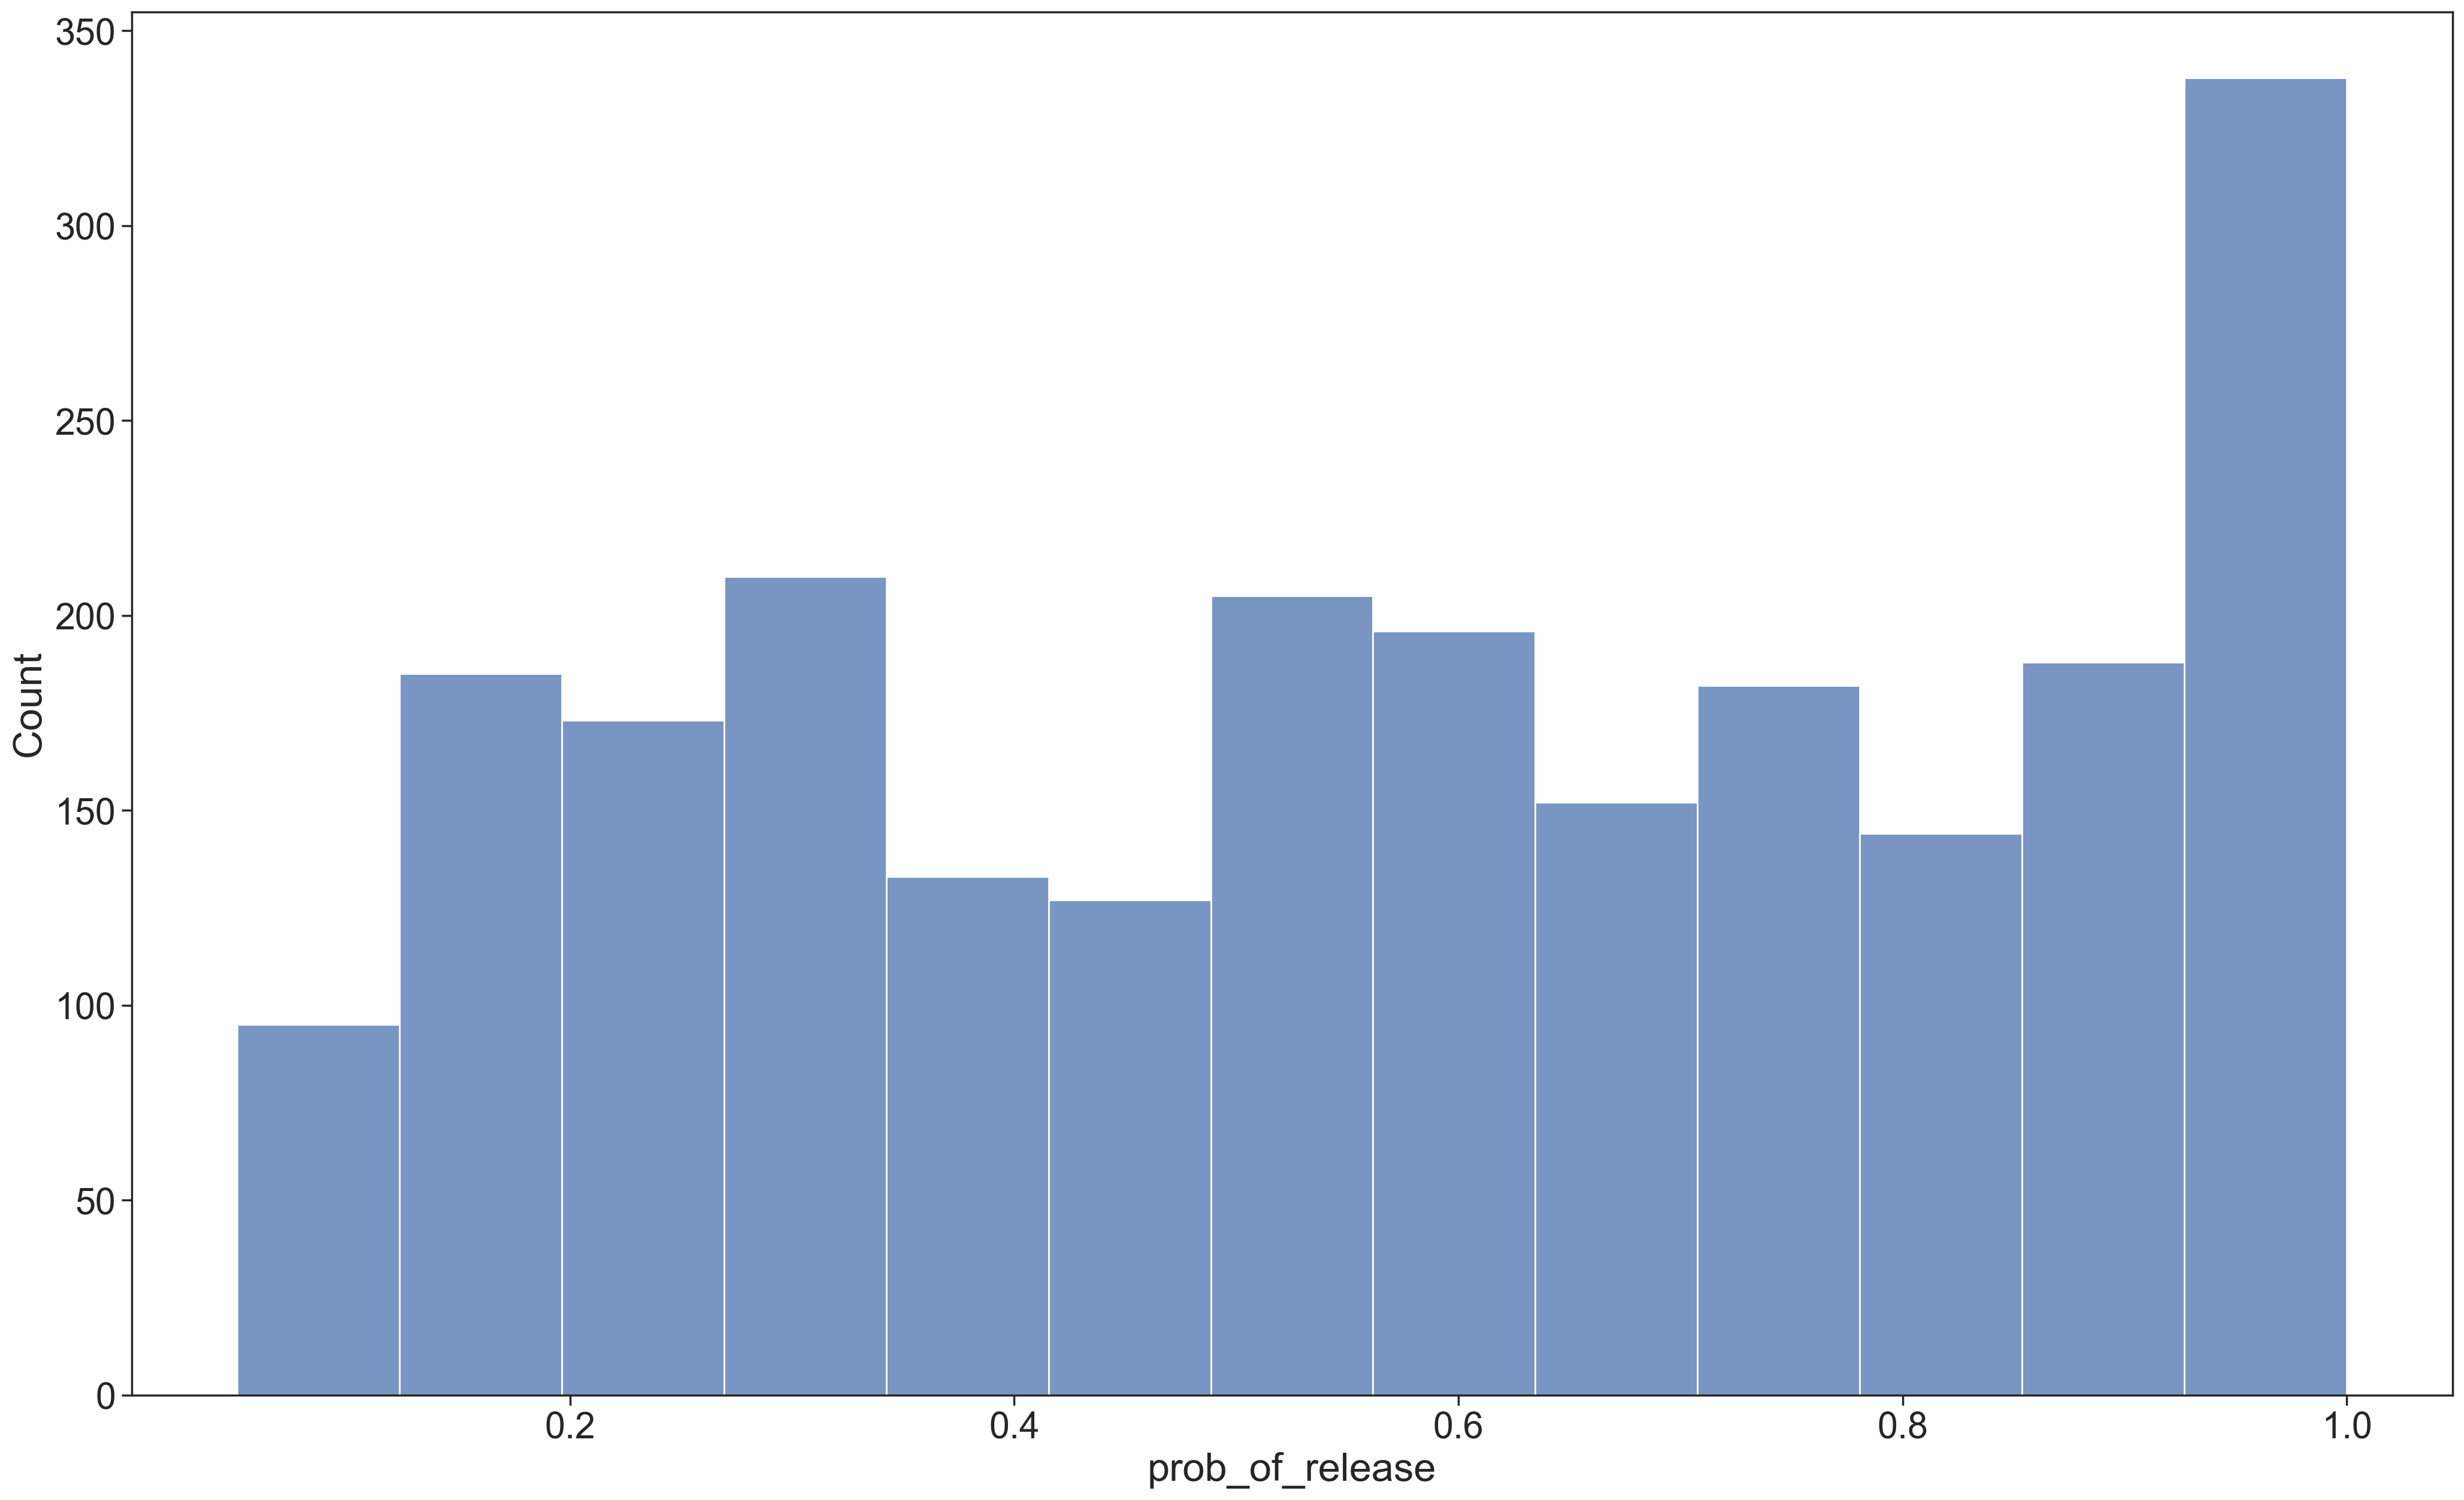

In [20]:
sns.histplot(x=df["prob_of_release"])

<Axes: xlabel='binary_target', ylabel='Count'>

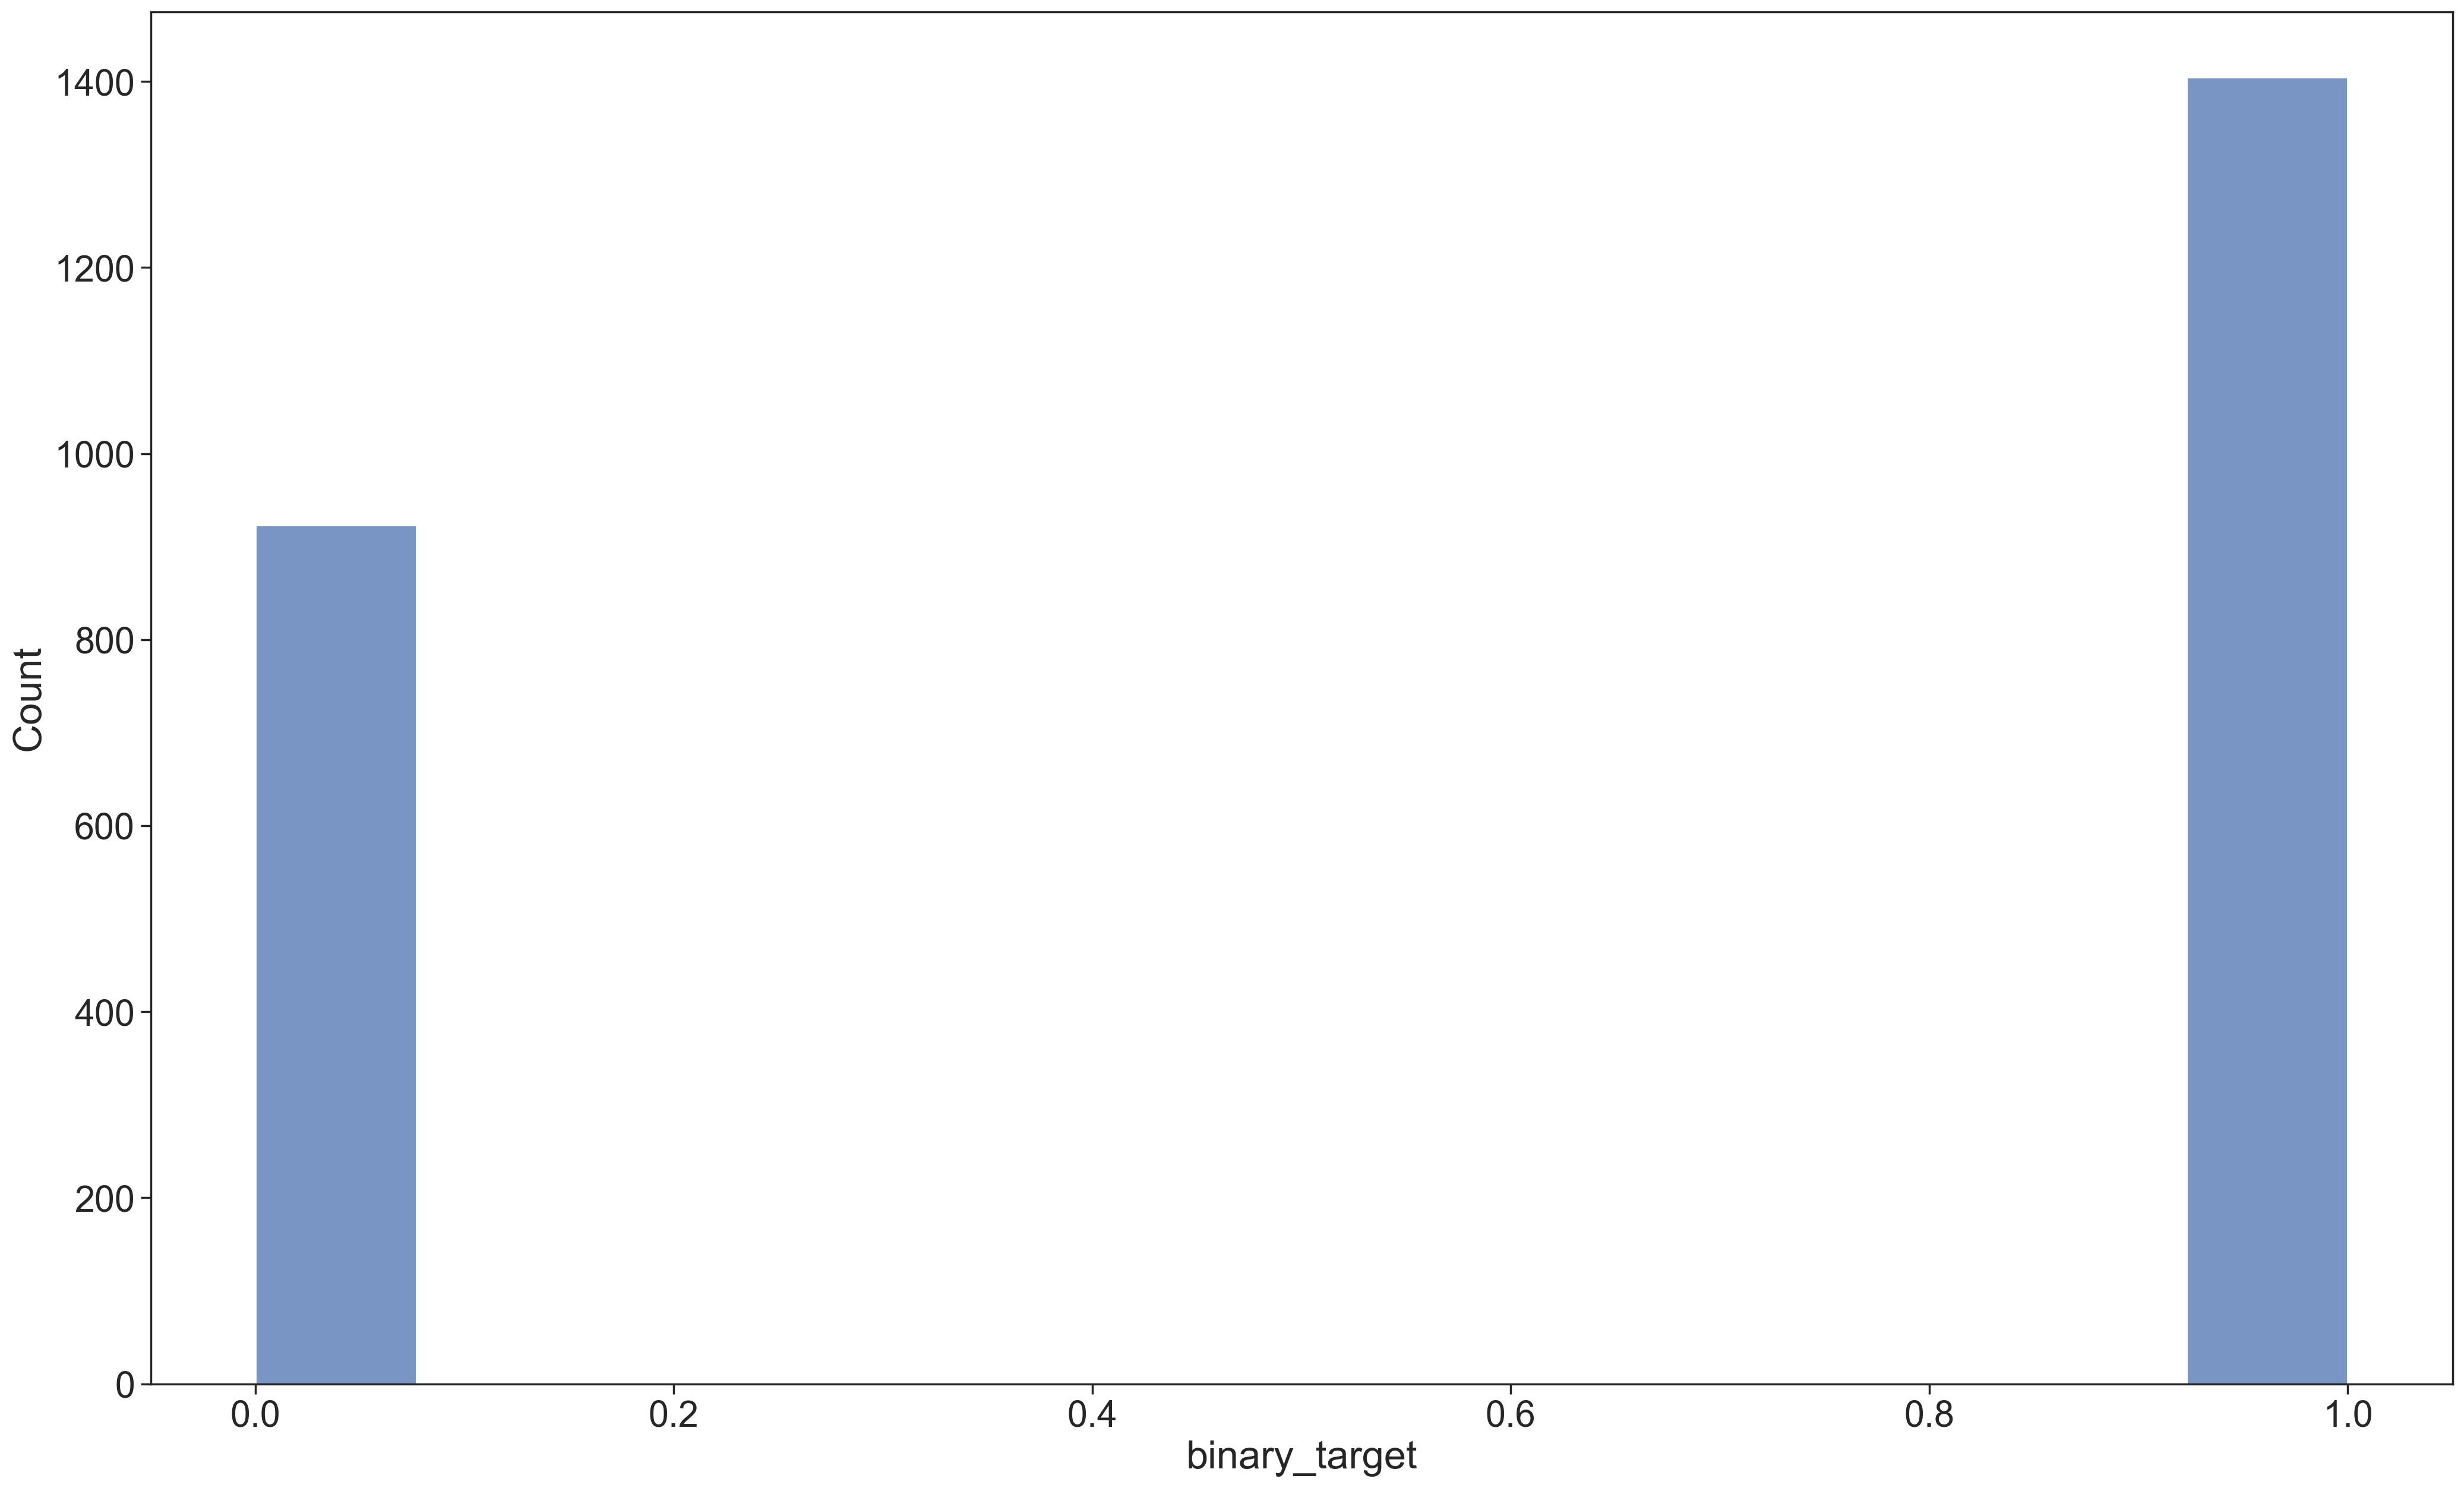

In [21]:
sns.histplot(x=df["binary_target"])

In [22]:
# sns.barplot(data=df, x="month_holidays", y="prob_of_release")

## Model-Building and Evaluation

In [23]:
train_df = df[0:int(len(df) * 0.90)].copy()
test_df = df[~df.index.isin(train_df.index)].copy()
print(len(train_df), len(test_df))

2095 233


In [24]:
features = [c for c in df.columns if c not in ["index", "prob_of_release", "release_post", "binary_target"]]
features

['days_since_previous_release',
 'month_holidays',
 'WD_Friday',
 'WD_Monday',
 'WD_Saturday',
 'WD_Sunday',
 'WD_Thursday',
 'WD_Tuesday',
 'WD_Wednesday',
 'M_Apr',
 'M_Aug',
 'M_Dec',
 'M_Feb',
 'M_Jan',
 'M_Jul',
 'M_Jun',
 'M_Mar',
 'M_May',
 'M_Nov',
 'M_Oct',
 'M_Sep',
 'previous_release_post']

In [25]:
def train_model(train_df):
    ct = ColumnTransformer(remainder="passthrough",
                           transformers=[
                               ("ss", StandardScaler(), ["days_since_previous_release", "month_holidays"])])

    pipeline = Pipeline(
        [("ct", ct), ("lr", LogisticRegression(random_state=1024, class_weight="balanced"))])
    
    model = GridSearchCV(
        pipeline,
        param_grid={"lr__penalty" : [None, "l1", "l2", "elasticnet"],
                    "lr__C" : np.logspace(-3, 3, 7),
                    "lr__solver" : ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
                    "lr__l1_ratio" : [0.00001, 0.0001, 0.001, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1]},
        scoring="f1", cv=3, refit=True)

    model.fit(train_df[features], train_df["binary_target"])
    
    return model

In [26]:
model = train_model(train_df)

In [27]:
model.best_params_

{'lr__C': 0.1,
 'lr__l1_ratio': 0.001,
 'lr__penalty': 'elasticnet',
 'lr__solver': 'saga'}

In [28]:
model.best_score_

0.8328454787947063

In [29]:
sorted(zip(model.best_estimator_.feature_names_in_, model.best_estimator_["lr"].coef_[0]),
       key=lambda x : x[1], reverse=True)

[('days_since_previous_release', 2.535034886916465),
 ('M_Sep', 0.35585788859577544),
 ('M_Jul', 0.2104722405630549),
 ('WD_Tuesday', 0.1520458964749273),
 ('month_holidays', 0.09811321756377106),
 ('WD_Monday', 0.09719547118664176),
 ('M_Oct', 0.07453435727801681),
 ('M_Nov', 0.06014579057433536),
 ('M_Jan', 0.05270227083865175),
 ('M_Apr', 0.046013415917873085),
 ('M_May', 0.035261659057359854),
 ('M_Jun', 0.028897889181279245),
 ('WD_Friday', 0.022108404814579635),
 ('WD_Wednesday', 0.008888858410661388),
 ('WD_Sunday', -0.05382401018307613),
 ('M_Aug', -0.10067470983007894),
 ('WD_Saturday', -0.11141309275718503),
 ('WD_Thursday', -0.11222494558285794),
 ('M_Feb', -0.2414999581527039),
 ('M_Mar', -0.25611934560547933),
 ('M_Dec', -0.26579681711165937),
 ('previous_release_post', -0.3834976440234486)]

In [30]:
test_df["predicted_binary"] = model.predict(test_df[features])

In [31]:
tp = len(test_df.query('binary_target == 1 & predicted_binary == 1'))
fp = len(test_df.query('binary_target != 1 & predicted_binary == 1'))
fn = len(test_df.query('binary_target == 1 & predicted_binary != 1'))

precision = tp / (tp + fp)
recall = tp / (tp + fn)

(round(precision, 4), round(recall, 4))

(0.9722, 0.7192)

In [32]:
test_df[["predicted_0", "predicted_prob"]] = model.predict_proba(test_df[features])
del test_df["predicted_0"]

In [33]:
mape(test_df["prob_of_release"], test_df["predicted_prob"])

0.3271899216151912

In [38]:
test_df["residuals"] = test_df["predicted_prob"] - test_df["prob_of_release"]
# sns.scatterplot(data=test_df, x="predicted_prob", y="residuals", s=75)

In [35]:
test_df[["index", "prob_of_release", "predicted_prob", "residuals"]].sort_values(by=["residuals"])

,index,prob_of_release,predicted_prob,residuals
2112,2022-12-09,1.000000,0.075613,-0.924387
2234,2023-04-10,1.000000,0.190712,-0.809288
2327,2023-07-12,1.000000,0.202743,-0.797257
2191,2023-02-26,1.000000,0.296933,-0.703067
2259,2023-05-05,1.000000,0.315977,-0.684023
...,...,...,...,...
2252,2023-04-28,0.700000,0.906704,0.206704
2242,2023-04-18,0.727273,0.959413,0.232140
2172,2023-02-07,0.600000,0.834882,0.234882
2240,2023-04-16,0.545455,0.808331,0.262877


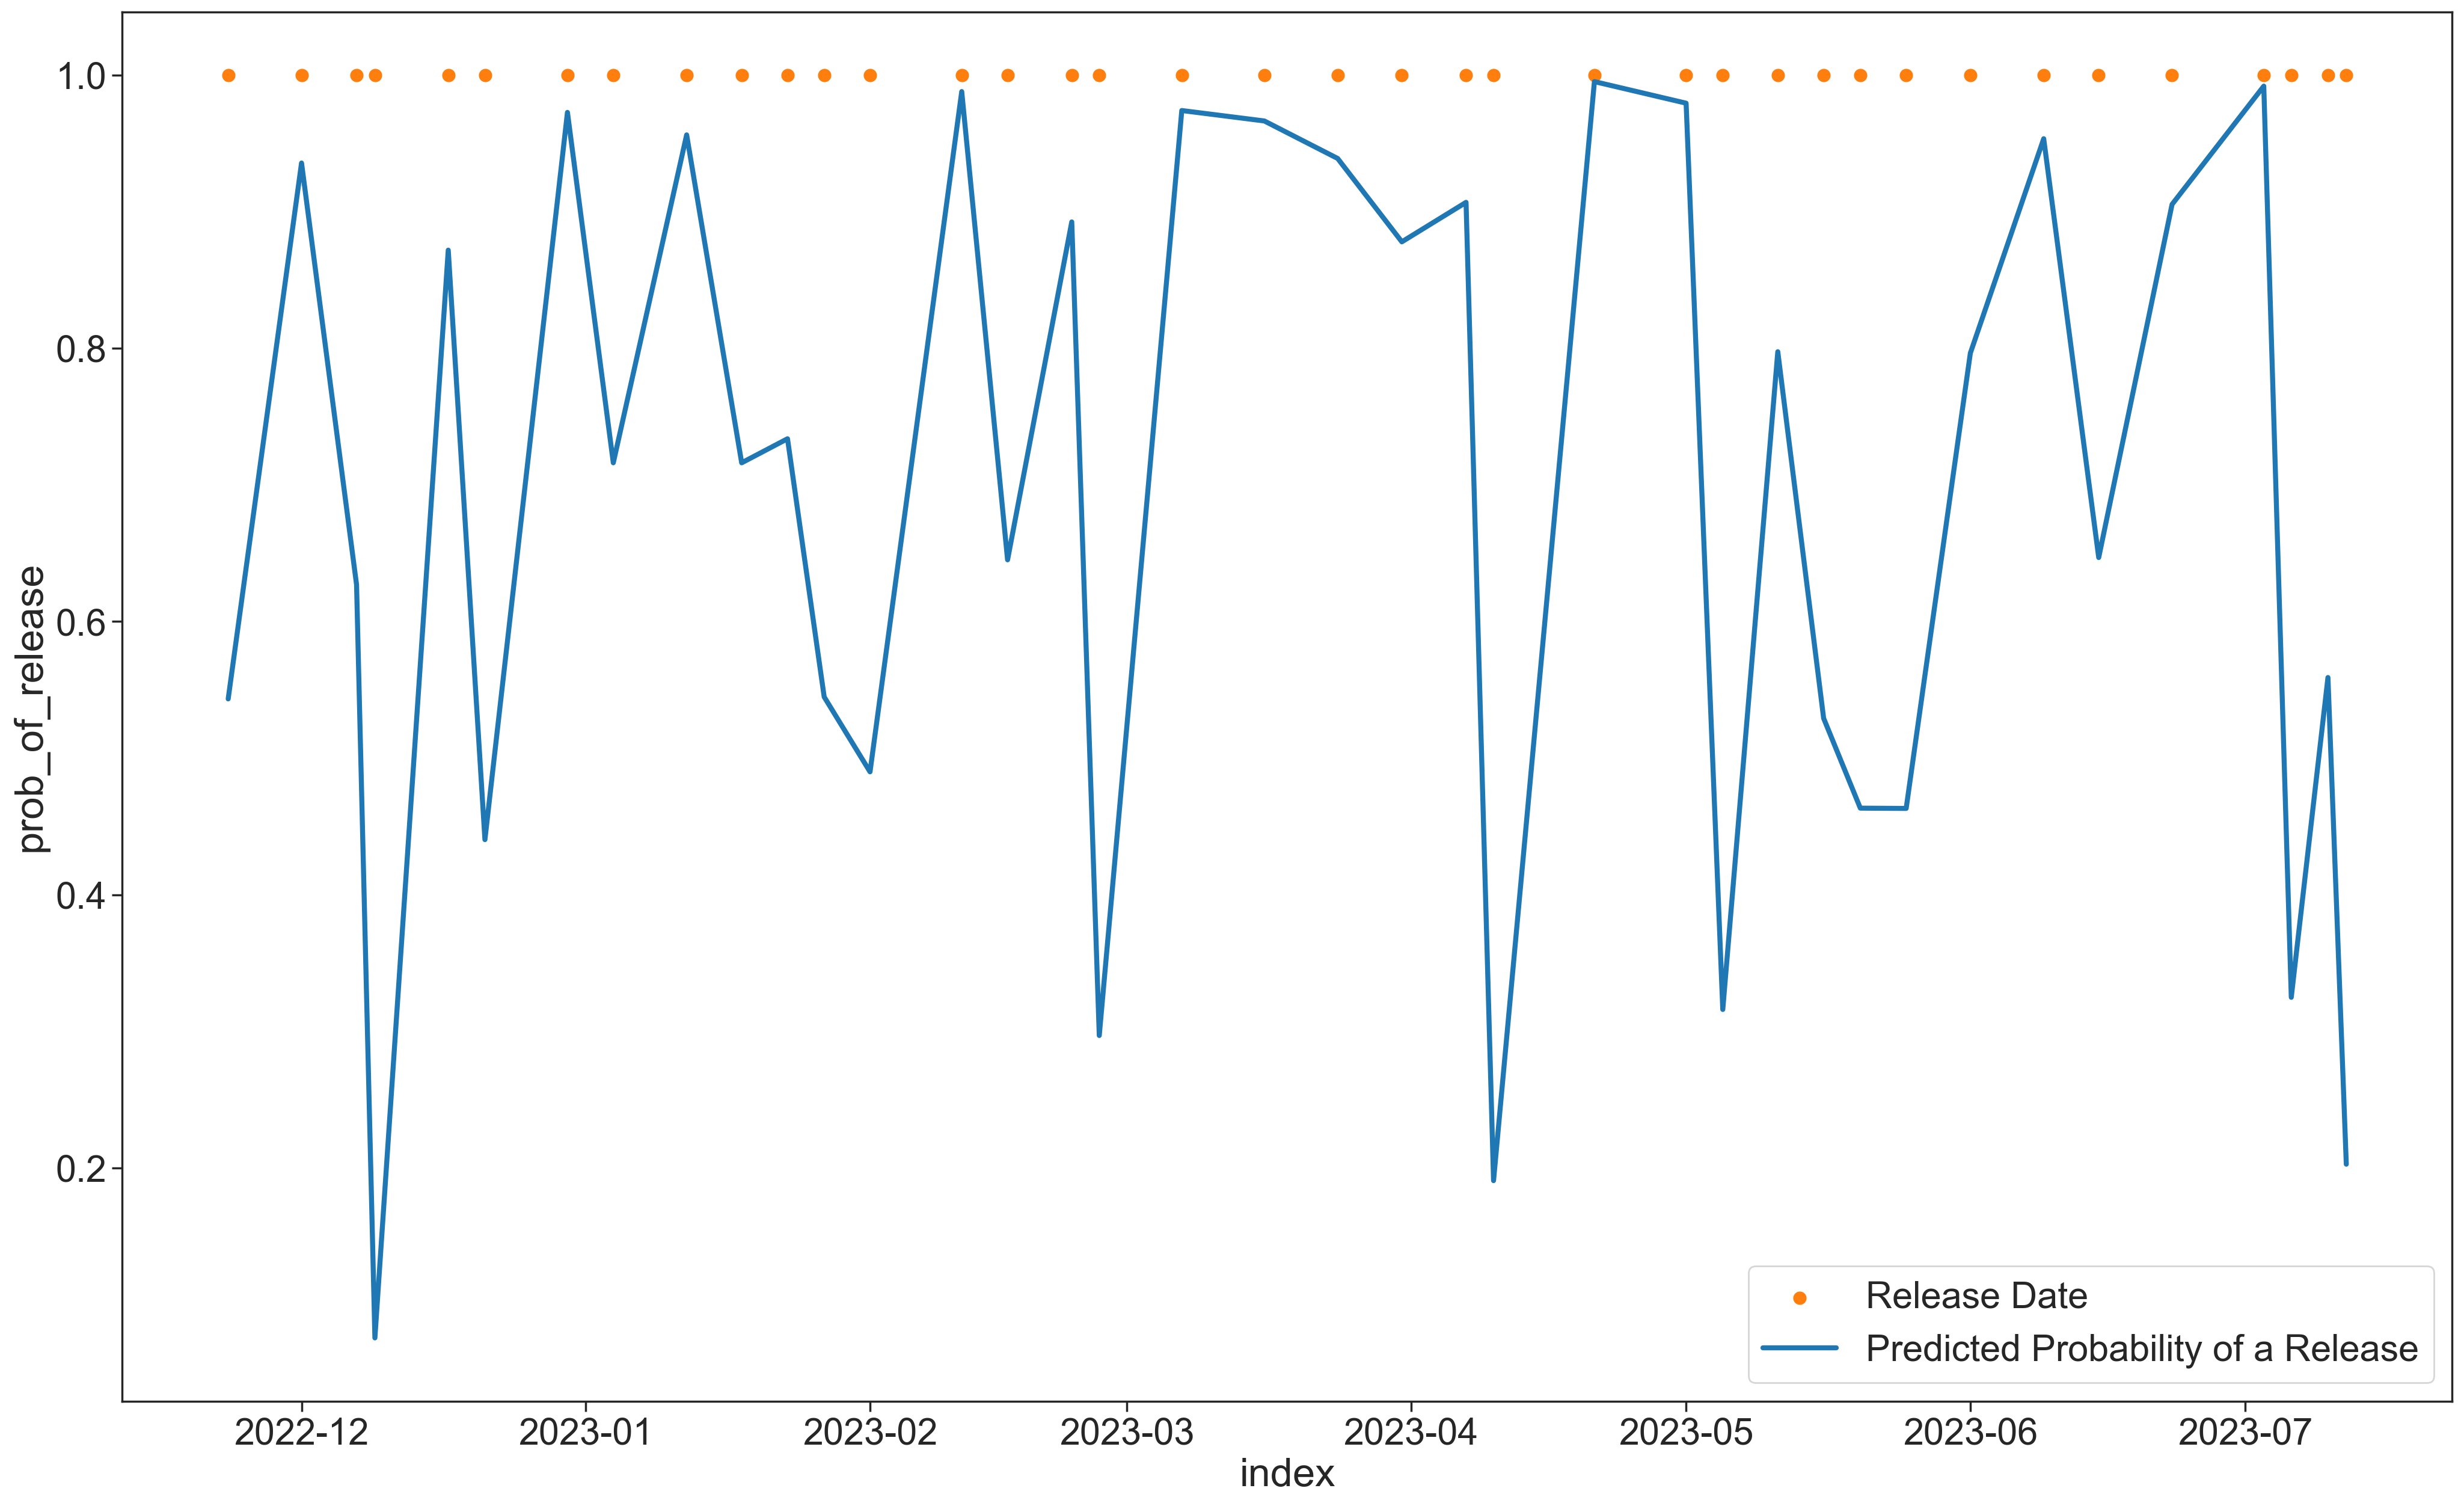

In [36]:
ax = sns.scatterplot(data=test_df[test_df["prob_of_release"] == 1], x="index", y="prob_of_release",
                     label="Release Date", s=75, color="tab:orange")
sns.lineplot(data=test_df[test_df["prob_of_release"] == 1], x="index", y="predicted_prob", ax=ax,
             label="Predicted Probability of a Release", color="tab:blue", linewidth=3)
plt.show()

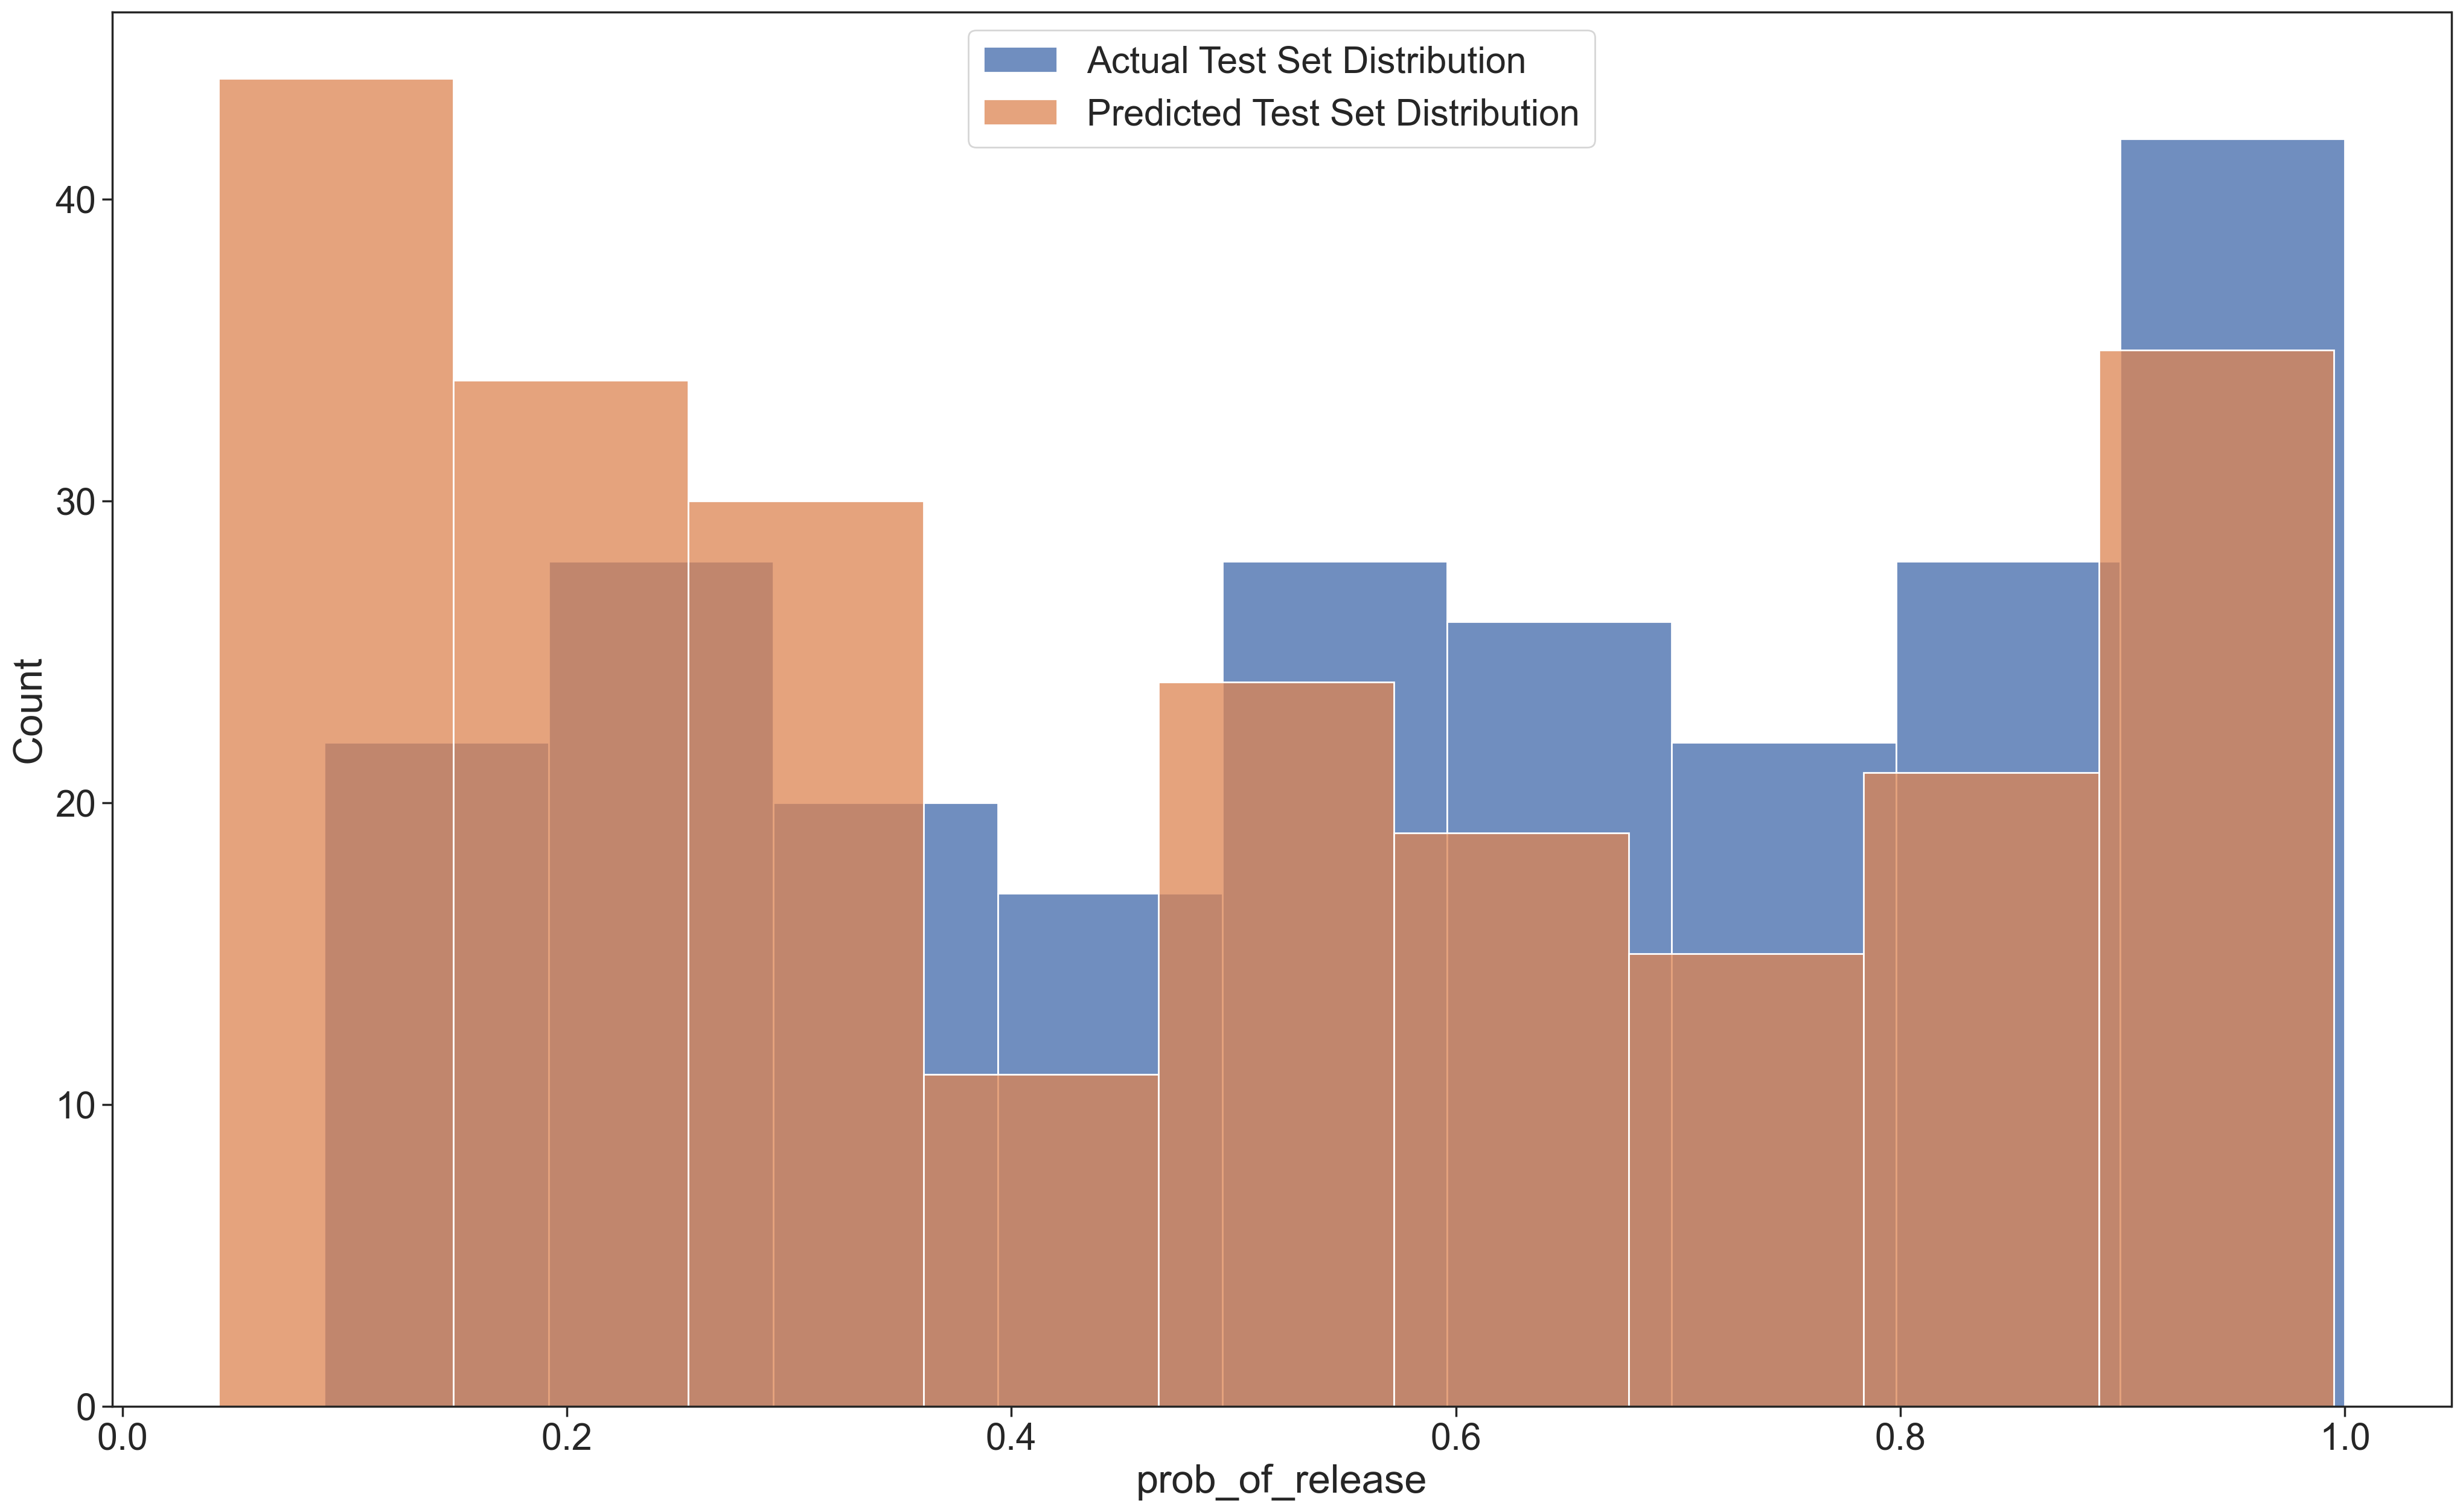

In [37]:
ax = sns.histplot(x=test_df["prob_of_release"], alpha=0.8, label="Actual Test Set Distribution")
sns.histplot(x=test_df["predicted_prob"], ax=ax, label="Predicted Test Set Distribution")
ax.legend()
plt.show()

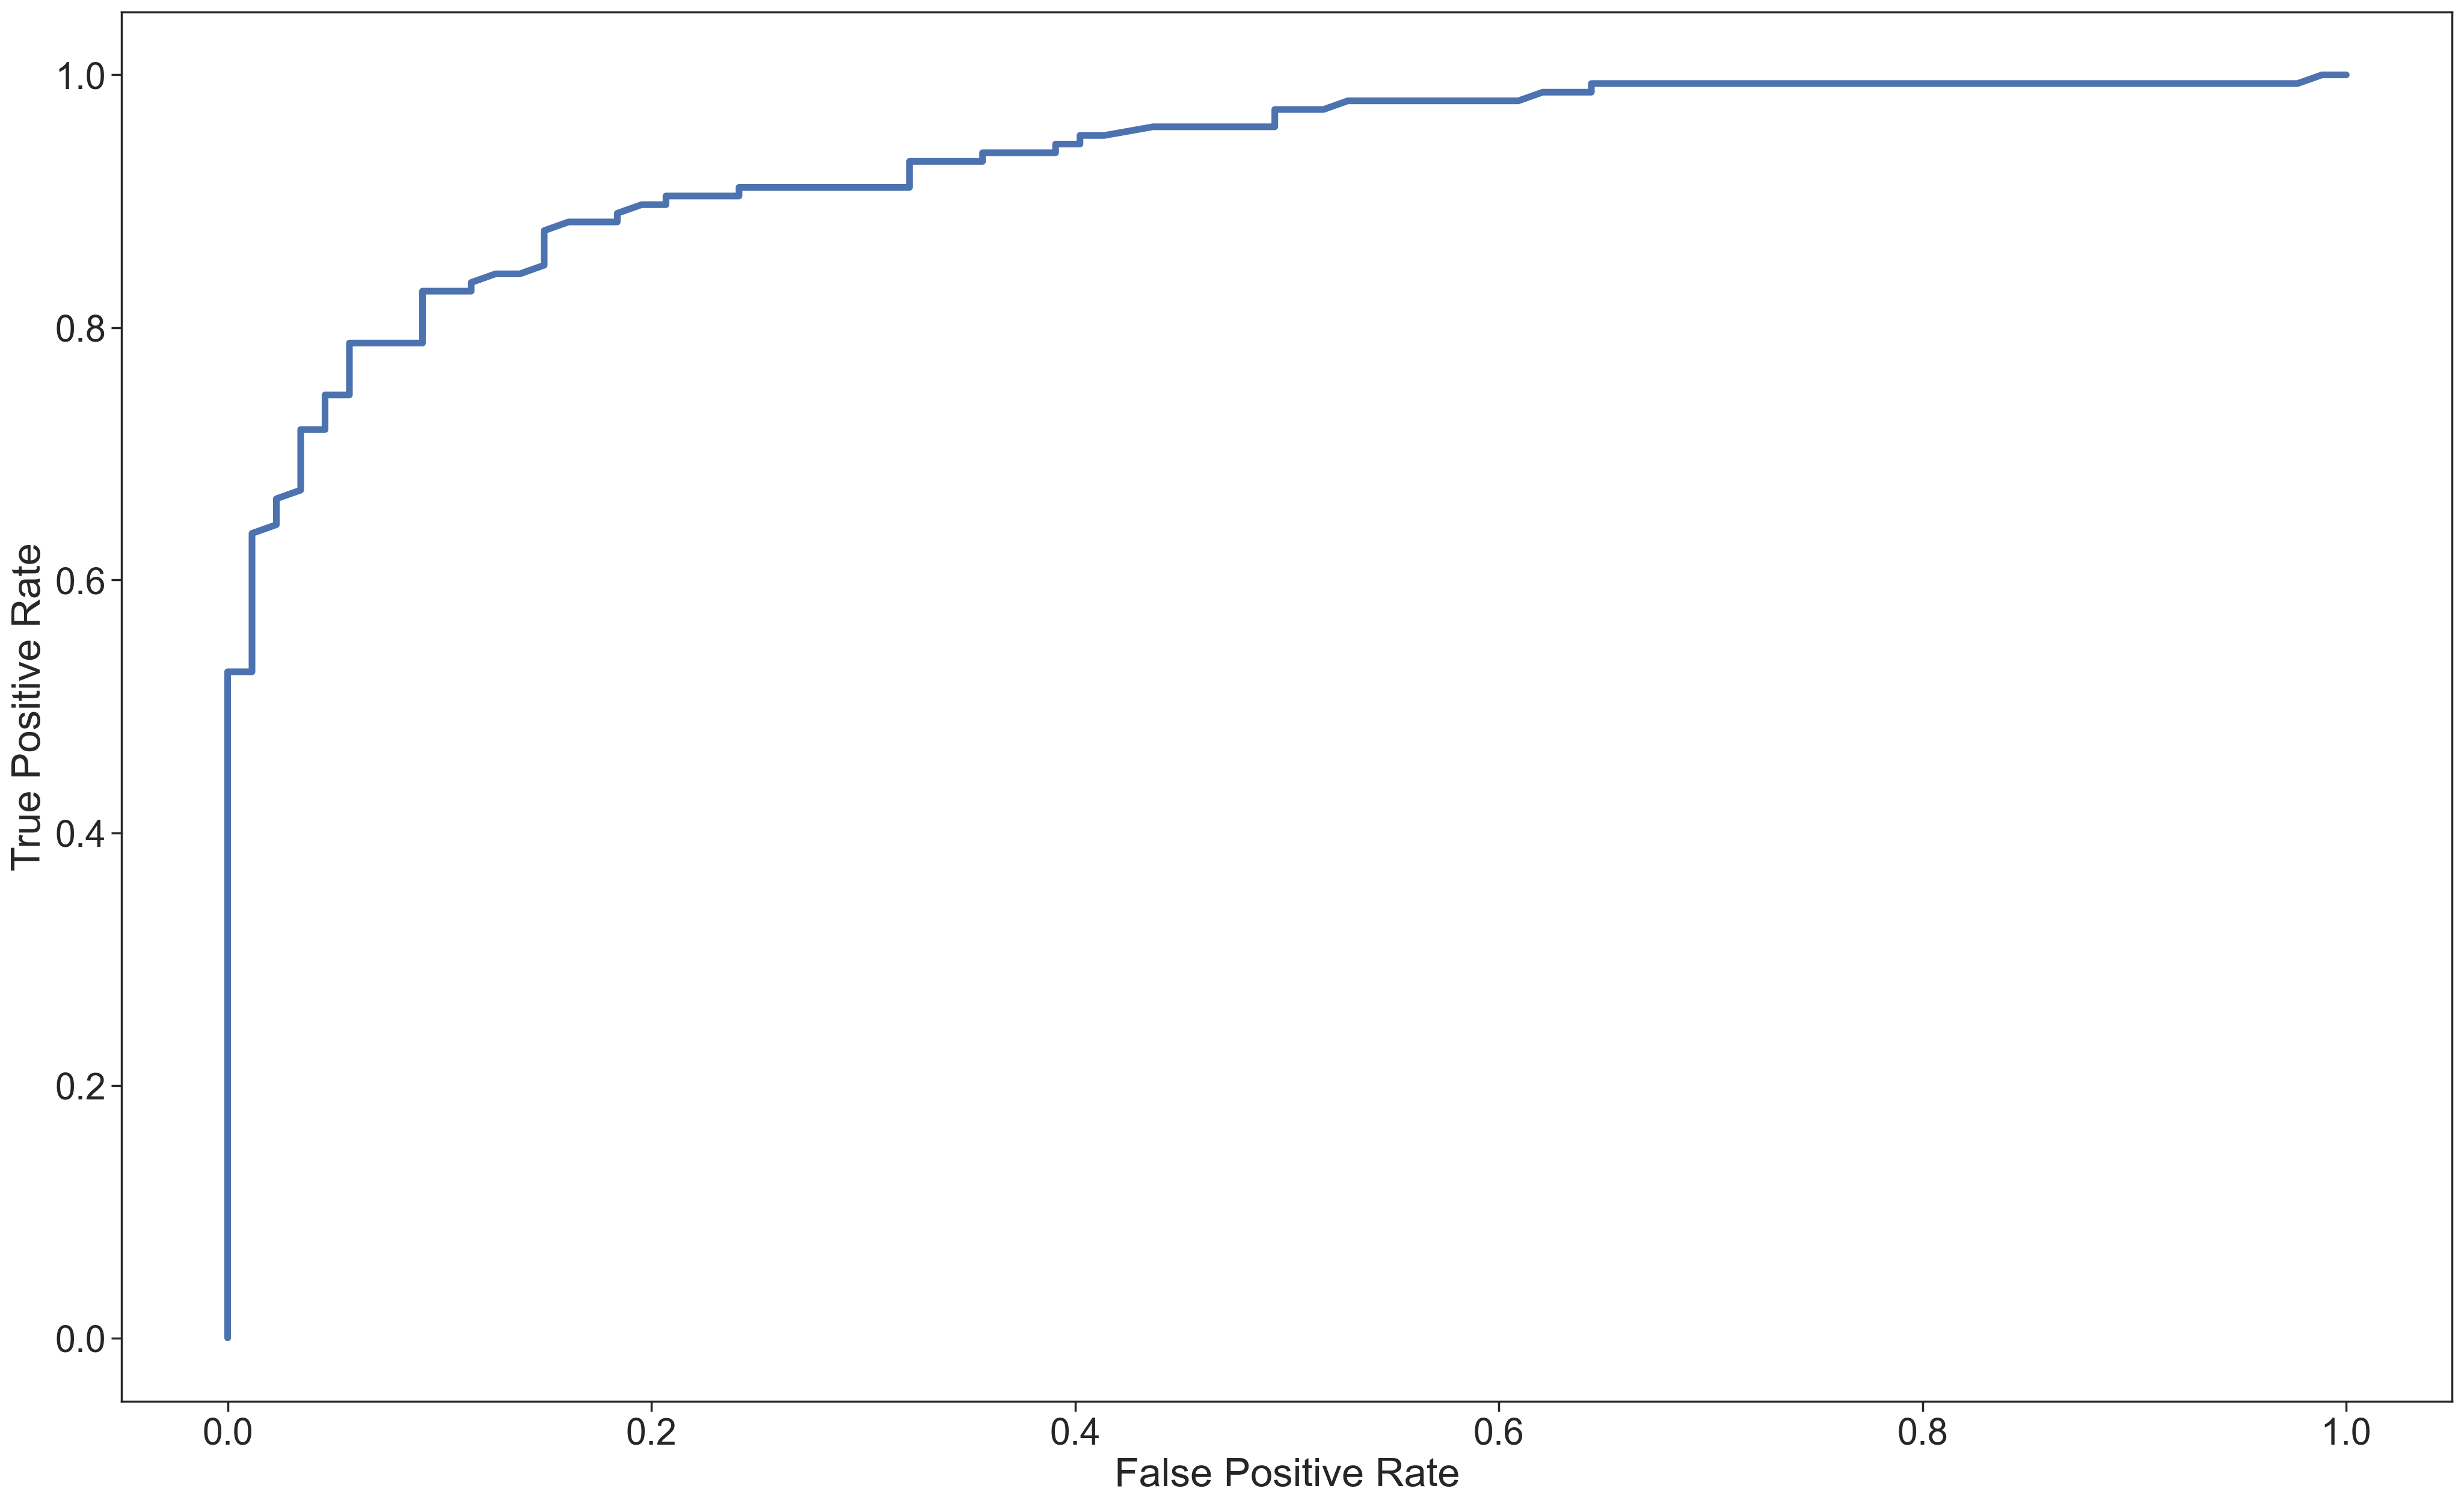

In [48]:
fp_rate, tp_rate, thresholds = roc_curve(test_df["binary_target"], test_df["predicted_prob"], pos_label=1)
RocCurveDisplay(fpr=fp_rate, tpr=tp_rate).plot(linewidth=4)
# sns.lineplot(x=thresholds, y=tp_rate)

## Predictions for the Next Month

In [45]:
model = train_model(df)

In [49]:
last_release_date = test_df[test_df["prob_of_release"] == 1][-1:].iloc[0]["index"]
next_month = pandas.DataFrame([{"index" : t} for t in 
                               pandas.date_range(start=last_release_date, freq="1D", periods=31)])
next_month = next_month[1:].copy()
next_month["days_since_previous_release"] = range(1, len(next_month) + 1)
next_month["previous_release_post"] = [1] + [0] * 29
next_month = get_features(next_month)

for f in features:
    if f not in next_month.columns:
        next_month[f] = 0

In [50]:
next_month["predicted_binary"] = model.predict(next_month[features])

In [51]:
next_month[["predicted_0", "predicted_prob"]] = model.predict_proba(next_month[features])
del next_month["predicted_0"]

In [52]:
next_month[["index", "predicted_prob", "predicted_binary"]]

,index,predicted_prob,predicted_binary
1,2023-07-13,0.070040,0
2,2023-07-14,0.152341,0
3,2023-07-15,0.300138,0
4,2023-07-16,0.505768,1
5,2023-07-17,0.709466,1
6,2023-07-18,0.854579,1
7,2023-07-19,0.932907,1
8,2023-07-20,0.970743,1
9,2023-07-21,0.987527,1
10,2023-07-22,0.994735,1


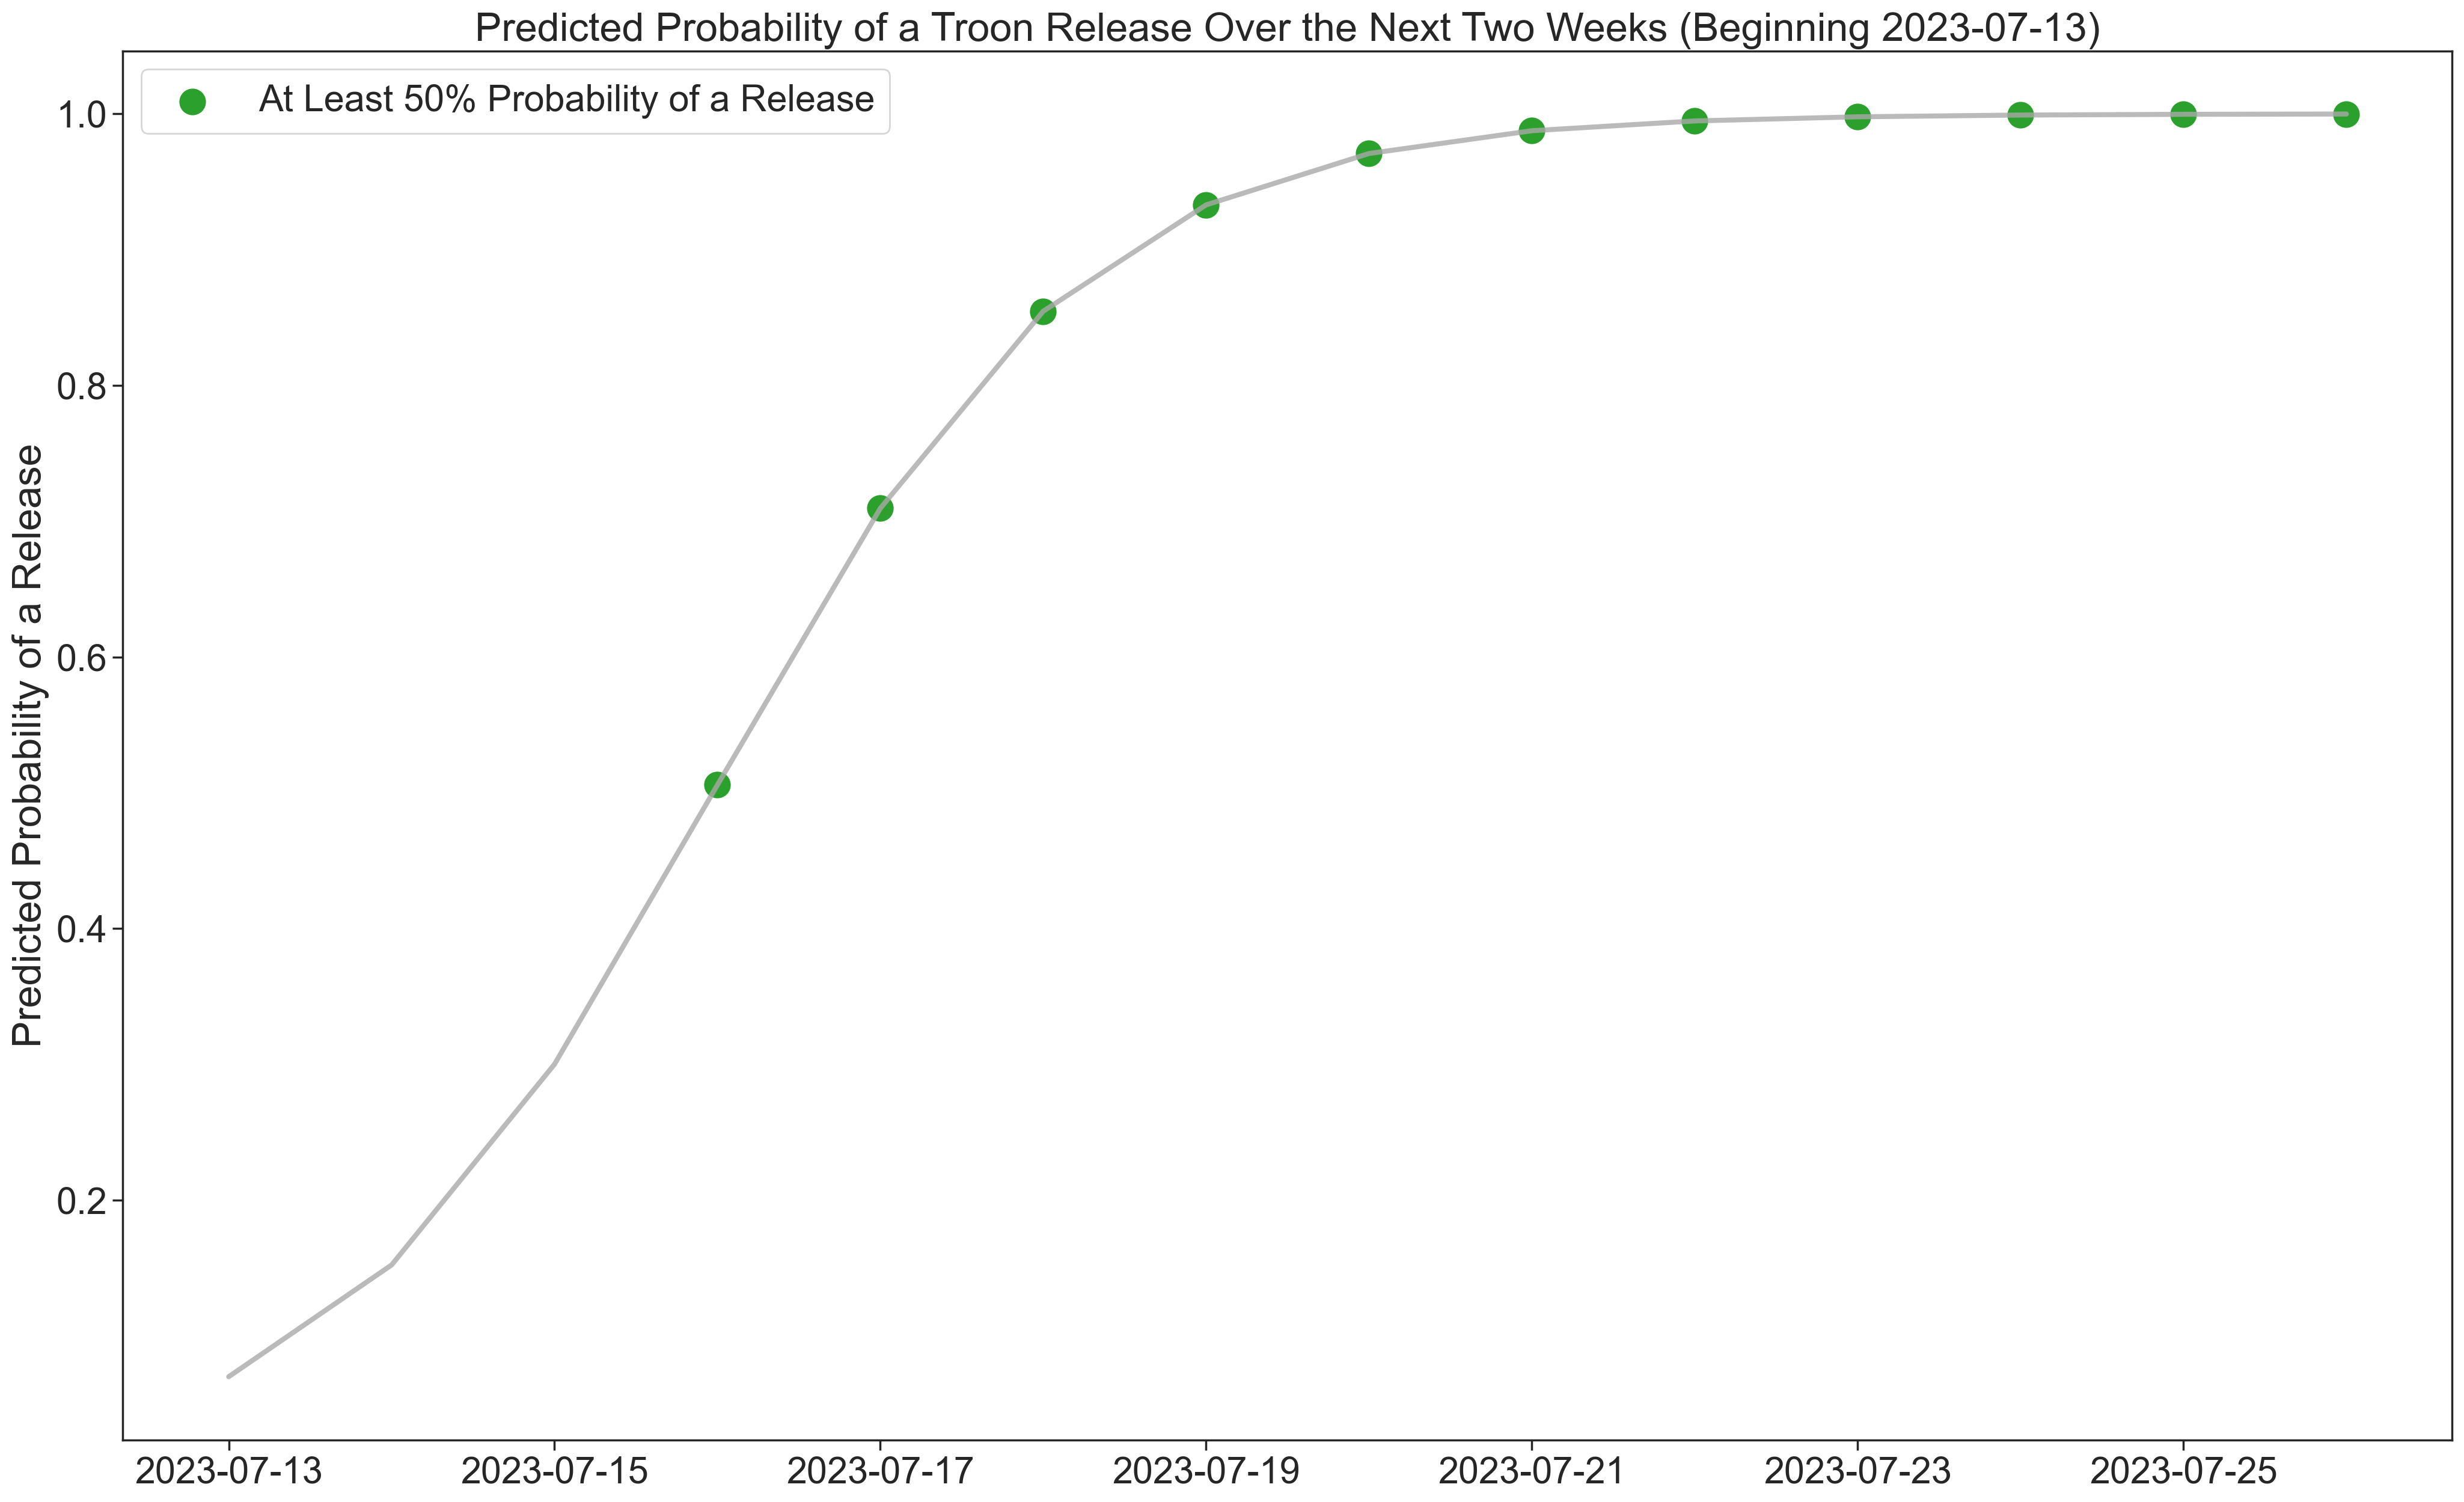

In [54]:
ax = sns.lineplot(data=next_month[:14], x="index", y="predicted_prob", linewidth=3, color="darkgrey", alpha=0.8)
sns.scatterplot(data=next_month[:14][next_month["predicted_prob"] >= 0.50], x="index", y="predicted_prob",
                s=300, ax=ax, color="tab:green", label="At Least 50% Probability of a Release")
ax.set_xlabel(None)
ax.set_ylabel("Predicted Probability of a Release")
ax.set_title("Predicted Probability of a Troon Release Over the Next Two Weeks (Beginning {})".format(
    next_month["index"].iloc[0].date()))
plt.show()